[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.36s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.41s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.39s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.36s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.43s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.39s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.40s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.36s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.19, time = 0.51s
Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.92      0.92      0.92       184
           2       0.93      0.96      0.94       166
           3       0.94      0.88      0.91       19

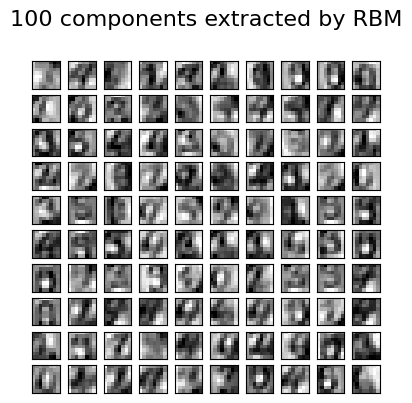

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [13]:
"""
Using MNIST, compare classification performance of:
1) logistic regression by itself,
2) logistic regression on outputs of an RBM, and
3) logistic regression on outputs of a stacks of RBMs / a DBN.
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


def norm(arr):
    arr = arr.astype(np.float)
    arr -= arr.min()
    arr /= arr.max()
    return arr


if __name__ == '__main__':

    # load MNIST data set
    X, y = datasets.load_digits(return_X_y=True)

    # normalize inputs to 0-1 range
    X = norm(X)

    # split into train, validation, and test data sets
    X_train, X_test, Y_train, Y_test = train_test_split(X,       Y,       test_size=10000, random_state=0)
    X_train, X_val,  Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=10000, random_state=0)

    # --------------------------------------------------------------------------------
    # set hyperparameters

    learning_rate = 0.02 # from Erhan et el. (2010): median value in grid-search
    total_units   =  800 # from Erhan et el. (2010): optimal for MNIST / only slightly worse than 1200 units when using InfiniteMNIST
    total_epochs  =   50 # from Erhan et el. (2010): optimal for MNIST
    batch_size    =  128 # seems like a representative sample; backprop literature often uses 256 or 512 samples

    C = 100. # optimum for benchmark model according to sklearn docs: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

    # TODO optimize using grid search, etc

    # --------------------------------------------------------------------------------
    # construct models

    # RBM
    rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

    # "output layer"
    logistic = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial', max_iter=200, verbose=1)

    models = []
    models.append(Pipeline(steps=[('logistic', clone(logistic))]))                                              # base model / benchmark
    models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('logistic', clone(logistic))]))                        # single RBM
    models.append(Pipeline(steps=[('rbm1', clone(rbm)), ('rbm2', clone(rbm)), ('logistic', clone(logistic))]))  # RBM stack / DBN

    # --------------------------------------------------------------------------------
    # train and evaluate models

    for model in models:
        # train
        model.fit(X_train, Y_train)

        # evaluate using validation set
        print("Model performance:\n%s\n" % (
            classification_report(Y_val, model.predict(X_val))))

    # TODO: after parameter optimization, evaluate on test set

C:\Users\Alaric\AppData\Local\Temp\ipykernel_12008\1357290370.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = arr.astype(np.float)


ValueError: Found input variables with inconsistent numbers of samples: [1797, 8985]